### Normalize the data. So see percentage
### Find the days it does the worse on and see if there are any common trends

### Libraries

In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


### Reading in the data and examing it

In [2]:
df = pd.read_csv("S&P500 Data.csv")

#adding in Dax data
dax_df = pd.read_csv("Dax Data.csv")
#drop Adj Close because it's the same as Close
del df["Adj Close"]
del dax_df["Adj Close"]
#df = df.join(dax_df, rsuffix = "_Dax")
df = pd.merge(df, dax_df, left_on="Date", right_on="Date")
df[["Open_y", "High_y", "Low_y", "Close_y", "Volume_y"]] = df[["Open_y", "High_y", "Low_y", "Close_y", "Volume_y"]].shift(-1)
del df["Date"]
df = df.dropna()
df = df.reset_index(drop=True)
df

,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y
0,255.949997,261.779999,255.949997,258.630005,209520000,1006.010010,1006.010010,1006.010010,1006.010010,0.0
1,258.640015,259.790009,257.179993,258.890015,169730000,1014.469971,1014.469971,1014.469971,1014.469971,0.0
2,258.869995,261.320007,256.179993,261.070007,175360000,1026.689941,1026.689941,1026.689941,1026.689941,0.0
3,261.049988,261.070007,242.949997,243.399994,197300000,987.520020,987.520020,987.520020,987.520020,0.0
4,243.380005,247.509995,241.070007,247.490005,158980000,986.890015,986.890015,986.890015,986.890015,0.0
...,...,...,...,...,...,...,...,...,...,...
8079,3500.020020,3549.850098,3499.610107,3534.219971,3428970000,13132.900390,13132.900390,12959.700200,13018.990230,52838000.0
8080,3534.010010,3534.010010,3500.860107,3511.929932,3605150000,13012.690430,13066.440430,12975.120120,13028.059570,52929600.0
8081,3515.469971,3527.939941,3480.550049,3488.669922,3840630000,12826.129880,12839.549810,12599.820310,12703.750000,78930900.0
8082,3453.719971,3489.080078,3440.889893,3483.340088,3717640000,12773.349610,12955.860350,12733.059570,12908.990230,76567800.0


### Looking at the closing price history for S&P 500

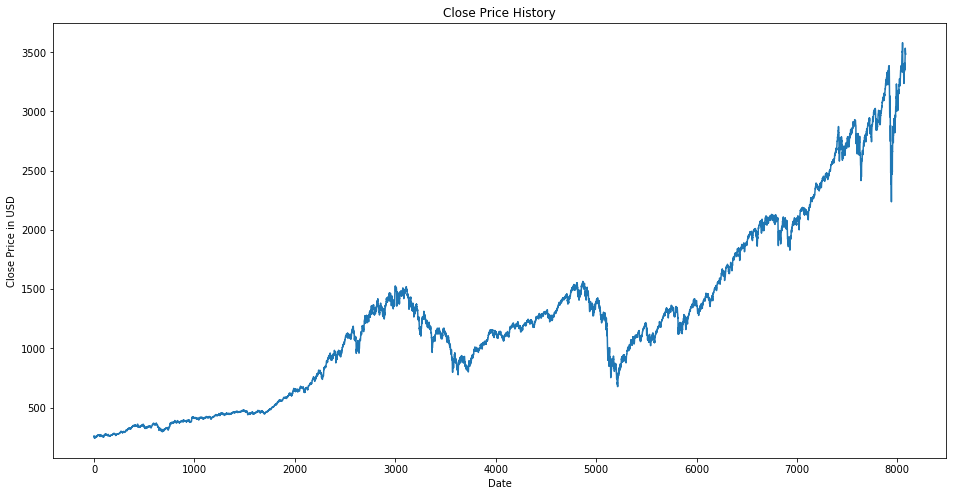

In [124]:
plt.figure(figsize = (16, 8))
plt.plot(df["Close_x"])
plt.title("Close Price History")
plt.xlabel("Date")
plt.ylabel("Close Price in USD")
plt.show()

### Adding 5 day closing average to data and Percent change

In [3]:
#for S&P500
five_avg = 1269.48
prev = 258.630005
five_avg_list = [248.208, 250.82, 253.68, 256.322, 255.586]
for close in range(5, len(df.index)):
    five_avg -= prev
    five_avg += df.loc[close]["Close_x"]
    five_avg_list.append(five_avg/5)
    prev = df.loc[close - 5]["Close_x"]
df["5_Day_Average_x"] = five_avg_list
#now for the Dax
five_avg = 1000
prev = 1006.010010
five_avg_list = [1006, 1010, 1018, 1001, 1000]
for close in range(5, len(df.index)):
    five_avg -= prev
    five_avg += df.loc[close]["Close_y"]
    five_avg_list.append(five_avg/5)
    prev = df.loc[close - 5]["Close_x"]
df["5_Day_Average_y"] = five_avg_list
percent_x = [0]
percent_y = [0]
for close in range(len(df.index) - 1):
    prev_x = df.loc[close]["Close_x"]
    curr_x = df.loc[close+1]["Close_x"]
    percent_x.append(round((curr_x - prev_x) / prev_x * 100, 4))
    prev_y = df.loc[close]["Close_y"]
    curr_y = df.loc[close+1]["Close_y"]
    percent_y.append(round((curr_y - prev_y) / prev_y * 100, 4))
df["Close_x_Percent_Change"] = percent_x
df["Close_y_Percent_Change"] = percent_y
df

,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y,5_Day_Average_x,5_Day_Average_y,Close_x_Percent_Change,Close_y_Percent_Change
0,255.949997,261.779999,255.949997,258.630005,209520000,1006.010010,1006.010010,1006.010010,1006.010010,0.0,248.208000,1.006000e+03,0.0000,0.0000
1,258.640015,259.790009,257.179993,258.890015,169730000,1014.469971,1014.469971,1014.469971,1014.469971,0.0,250.820000,1.010000e+03,0.1005,0.8409
2,258.869995,261.320007,256.179993,261.070007,175360000,1026.689941,1026.689941,1026.689941,1026.689941,0.0,253.680000,1.018000e+03,0.8421,1.2046
3,261.049988,261.070007,242.949997,243.399994,197300000,987.520020,987.520020,987.520020,987.520020,0.0,256.322000,1.001000e+03,-6.7683,-3.8152
4,243.380005,247.509995,241.070007,247.490005,158980000,986.890015,986.890015,986.890015,986.890015,0.0,255.586000,1.000000e+03,1.6804,-0.0638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8079,3500.020020,3549.850098,3499.610107,3534.219971,3428970000,13132.900390,13132.900390,12959.700200,13018.990230,52838000.0,4077.713984,7.282921e+06,1.6416,-0.9089
8080,3534.010010,3534.010010,3500.860107,3511.929932,3605150000,13012.690430,13066.440430,12975.120120,13028.059570,52929600.0,4098.379951,7.284845e+06,-0.6307,0.0697
8081,3515.469971,3527.939941,3480.550049,3488.669922,3840630000,12826.129880,12839.549810,12599.820310,12703.750000,78930900.0,4123.919941,7.286713e+06,-0.6623,-2.4893
8082,3453.719971,3489.080078,3440.889893,3483.340088,3717640000,12773.349610,12955.860350,12733.059570,12908.990230,76567800.0,4136.699971,7.288611e+06,-0.1528,1.6156


### Setting up data

In [4]:
#randomly shuffle the data
#df = df.sample(frac=1).reset_index(drop=True)

#Creating new dataframe with only the Close column
data = df.filter(["Close_x_Percent_Change"])

#Converting the dataframe to a numpy array
dataset = data.values

#only going to train on about 75% of the data
training_data_length = math.ceil(len(dataset) * .75)

#Scaling the data to be between 0 and 1
# scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(dataset)

#Creating the training data set
# train_data = scaled_data[0: training_data_length, :]
train_data = dataset[0: training_data_length, :]

#split the data into it's X and Y
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])

#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_trin = np.array(y_train)

#Have to reshape the data into 3 dim
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Building the LSTM model

In [11]:
model = Sequential()
model.add(LSTM(1024, return_sequences = True, input_shape = (x_train.shape[1] , 1)))
model.add(LSTM(512, return_sequences = False))
model.add(Dropout(.3))
model.add(Dense(256))
model.add(Dropout(.2))
model.add(Dense(128))
model.add(Dense(1))
#model.add(Dense(1, activation="softmax"))

#Compile the model
model.compile(optimizer = "adam", loss = "mean_squared_error")
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 1024)          4202496   
_________________________________________________________________
lstm_2 (LSTM)                (None, 512)               3147776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [102]:
#Train the model
checkpoint_path = "model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
model.fit(x_train, y_train, batch_size = 64, epochs = 5)
model.save("test")

Epoch 1/5
6003/6003 [==============================] - 27s 5ms/step - loss: 1.3870
Epoch 2/5
6003/6003 [==============================] - 26s 4ms/step - loss: 1.3863
Epoch 3/5
6003/6003 [==============================] - 26s 4ms/step - loss: 1.3786
Epoch 4/5
6003/6003 [==============================] - 26s 4ms/step - loss: 1.3771
Epoch 5/5
6003/6003 [==============================] - 26s 4ms/step - loss: 1.3691


In [5]:
#getting the saved model
model = keras.models.load_model("test")

### Test the model

In [6]:
#Test data
# test_data = scaled_data[training_data_length - 100: , :]
test_data = dataset[training_data_length - 60: , :]
#Creating the x_test and y_test data sets
x_test = []
y_test = dataset[training_data_length: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

#Convert x_test to a numpy array
x_test = np.array(x_test)

#Reshape the data into 3 dim
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Get the models predicted close price
pred = model.predict(x_test)
#have to undo the scaling
#pred = scaler.inverse_transform(pred)

In [7]:
#Getting the RMSE
rmse = np.sqrt(np.mean(((pred - y_test) ** 2)))
print(rmse)

1.0669635456444797


rmse, direction accuracy
32 batch
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent = 1.0903948317578935, 69.xxx
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent_100 = 1.082747707564304, 70.99009900990099
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent_200 = 1.0740236769749272, 70.59405940594058
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent_150 = 1.0755882936062169, 66.88118811881189
model_3_SP500_and_Dax_5_avg_4layers_25epoch_percent_100 = 1.0695466754755443, 66.43564356435644
model_3_SP500_and_Dax_5_avg_4layers_50epoch_percent_100 = 1.0991801038652034, 63.415841584158414
64 batch
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent_100_64batch = 1.0807688986003077, 52.02970297029703
128 batch
model_3_SP500_and_Dax_5_avg_4layers_10epoch_percent_150_128batch = 1.079575159318183, 42.524752475247524
256 batch
model_3_SP500_and_Dax_5_avg_4layers_50epoch_percent_256_256batch = 1.0762480391045421, 63.910891089108915

### Visualizing the predicted data

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


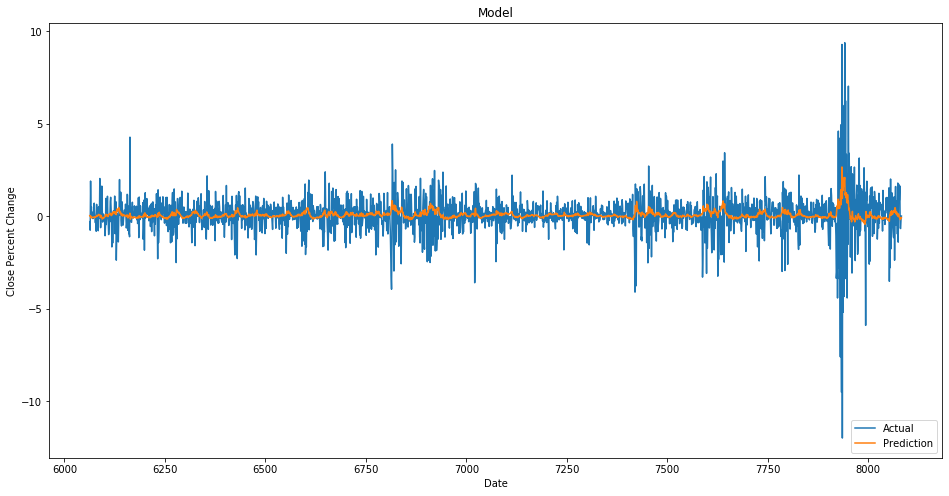

In [8]:
actual = data[training_data_length: ]
actual["Prediction"] = pred
#plotting the data
plt.figure(figsize = (16,8))
plt.plot(actual[["Close_x_Percent_Change", "Prediction"]])
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Close Percent Change")
plt.legend(["Actual", "Prediction"], loc = "lower right")
plt.show()

In [9]:
up_actual = []
up_pred = []
actual = actual.reset_index()
for row in range(len(actual.index) - 1):
    if actual.loc[row]["Close_x_Percent_Change"] >= actual.loc[row+1]["Close_x_Percent_Change"]:
        up_actual.append(0)
    else:
        up_actual.append(1)
    if actual.loc[row]["Prediction"] >= actual.loc[row+1]["Prediction"]:
        up_pred.append(0)
    else:
        up_pred.append(1)
correct = 0
for i in range(len(up_actual)):
    if up_actual[i] == up_pred[i]:
        correct += 1
print(correct / len(up_actual) * 100)

74.25742574257426


In [51]:
actual

,index,Close_x_Percent_Change,Prediction
0,6063,-0.2900,0.034961
1,6064,-0.7504,-0.005473
2,6065,1.9040,0.031017
3,6066,0.2329,-0.100879
4,6067,0.5107,-0.067520
5,6068,0.0621,-0.041647
6,6069,0.0414,-0.049140
7,6070,0.2188,-0.063516
8,6071,-0.1252,-0.078108
9,6072,-0.0128,-0.053848


## Simulation

#### Best Model (Test)

In [10]:
money = 5000
start = 5000
last_year = 5000
amount = 0
ann_return = []
base_return = []
#new_df = df[6063:].reset_index()
new_df = pd.read_csv("SPY.csv")
new_df = new_df.join(actual["Prediction"])
new_df.drop(new_df.tail(3).index, inplace=True)
pd.set_option('display.max_rows', new_df.shape[0]+1)
for row in range(len(new_df.index) - 1):
    #predicted to go UP tomorrow
    if up_pred[row] == 0 and money > 0:
        while True:
            if money - new_df.loc[row]["Open"] >= 0:
                amount += 1
                money -= new_df.loc[row]["Open"]
            else:
                break
    #predicted to go DOWN tomorrow
    elif up_pred[row] == 1 and amount != 0:
        money += new_df.loc[row]["Close"] * amount
        amount = 0
    if(row % 253 == 0 and row != 0) or (row == len(new_df.index) - 2):
        if amount == 0:
            m = money
        else:
            m = new_df.loc[row]["Close"] * amount
        ann_return.append((m - last_year) / last_year * 100)
        last_year = m
        base_return.append((new_df.loc[row]["Close"] - new_df.loc[row - 253]["Open"]) / new_df.loc[row - 253]["Open"] * 100)
money += new_df.loc[len(new_df) - 1]["Close"] * amount
print(money)
r = (money - start) / start
b_r = (new_df.loc[len(new_df) - 1]["Close"] - new_df.loc[0]["Open"]) / new_df.loc[0]["Open"]
annualized_return = (1 + r)**(1/8) - 1
baseline_return = (1 + b_r)**(1/8) - 1
print("Annualized Return: " + str(round(annualized_return * 100, 4)) + "%")
print("Baseline Annualized Return: " + str(round(baseline_return * 100, 4)) + "%")

11246.89939900002
Annualized Return: 10.6644%
Baseline Annualized Return: 11.5042%


In [11]:
new_df
ann_return
total = 0
for i in ann_return:
    total += i
print(total/len(ann_return))
total = 0
for i in base_return:
    total += i
print(total/len(base_return))

total = 0
for i in range(len(ann_return)-1):
    total += ann_return[i]
print(total/(len(ann_return) - 1))
total = 0
for i in range(len(base_return)-1):
    total += base_return[i]
print(total/(len(base_return)-1))

11.371803946951893
11.993518445957001
6.554372011859286
11.10982543910062


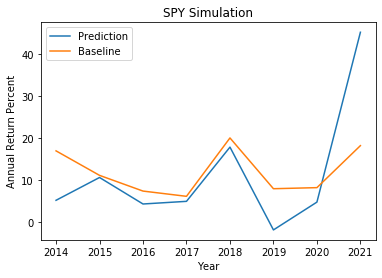

In [13]:
x = [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
plt.plot(x, ann_return)
plt.plot(x, base_return)
plt.xlabel("Year")
plt.ylabel("Annual Return Percent")
plt.title("SPY Simulation")
plt.legend(["Prediction", "Baseline"], loc = "upper left")

#### Baseline Model (just guessing)

In [57]:
import random as r

totals = []
for i in range(10):
    money = 5000
    amount = 0
    new_df = df[6063:].reset_index()
    new_df = new_df.join(actual["Prediction"])
    pd.set_option('display.max_rows', new_df.shape[0]+1)
    new_df
    for row in range(len(new_df.index) - 1):
        #predicted to go UP tomorrow
        rand = r.randrange(0,2)
        if rand == 0 and money > 0:
            while True:
                if money - new_df.loc[row]["Open_x"] >= 0:
                    amount += 1
                    money -= new_df.loc[row]["Open_x"]
                else:
                    break
        #predicted to go DOWN tomorrow
        elif rand and amount != 0:
            money += new_df.loc[row]["Close_x"] * amount
            amount = 0
    money += new_df.loc[len(new_df) - 1]["Close_x"] * amount
    totals.append(money)
print(totals)
print(sum(totals) / len(totals))

[8221.815340000037, 7680.086893999984, 9341.197346000008, 7454.180168000013, 7322.980964999996, 6364.863662999994, 8655.04051399998, 6718.261961000006, 8274.86044599999, 7982.243180000012]
7801.553047700002


In [151]:
new_df

,index,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y,5_Day_Average_x,5_Day_Average_y,Close_x_Percent_Change,Close_y_Percent_Change,Prediction
0,6063,1379.319946,1385.030029,1373.349976,1375.319946,4440920000,6756.160156,6855.709961,6596.209961,6606.089844,237751400.0,1593.037983,3.861788e+06,-0.2900,-2.1966,0.034961
1,6064,1375.130005,1375.130005,1354.650024,1365.000000,4193740000,6626.299805,6876.740234,6621.359863,6865.660156,176772100.0,1598.459980,3.862893e+06,-0.7504,3.9293,-0.005473
2,6065,1365.449951,1394.160034,1365.449951,1390.989990,3751170000,6845.879883,6943.319824,6845.879883,6918.720215,118895200.0,1604.653974,3.864005e+06,1.9040,0.7728,0.031017
3,6066,1391.040039,1399.630005,1391.040039,1394.229980,3122050000,6909.279785,6979.629883,6902.859863,6967.950195,132939500.0,1606.305976,3.865121e+06,0.2329,0.7115,-0.100879
4,6067,1394.459961,1407.140015,1394.459961,1401.349976,3682490000,6944.890137,6966.149902,6907.290039,6966.149902,121071700.0,1609.515961,3.866238e+06,0.5107,-0.0258,-0.067520
5,6068,1401.229980,1404.140015,1396.130005,1402.219971,3221790000,6979.410156,6989.149902,6891.490234,6964.990234,169141600.0,1614.095966,3.867355e+06,0.0621,-0.0166,-0.041647
6,6069,1402.260010,1405.949951,1398.800049,1402.800049,3119610000,6927.709961,6955.379883,6891.899902,6944.560059,142176100.0,1619.591987,3.868469e+06,0.0414,-0.2933,-0.049140
7,6070,1402.579956,1405.979980,1395.619995,1405.869995,2767980000,6935.509766,6976.310059,6882.029785,6909.680176,107657700.0,1627.765986,3.869578e+06,0.2188,-0.5023,-0.063516
8,6071,1405.869995,1405.869995,1397.319946,1404.109985,2499990000,6965.040039,6995.029785,6939.500000,6974.390137,91374900.0,1630.389985,3.870694e+06,-0.1252,0.9365,-0.078108
9,6072,1404.359985,1410.030029,1400.599976,1403.930054,2930900000,6953.009766,6972.640137,6910.390137,6946.799805,76009200.0,1632.330000,3.871805e+06,-0.0128,-0.3956,-0.053848


### Dates with Significant changes

In [68]:
index = []
for i in range(len(actual)):
    if actual.loc[i]["Close_x_Percent_Change"] >= 5 or actual.loc[i]["Close_x_Percent_Change"] <= -5:
        index.append(actual.loc[i]["Close_x_Percent_Change"])
for i in range(len(df)):
    if df.loc[i]["Close_x_Percent_Change"] in index:
        print(df.loc[i]["Date"])

3/9/2020
3/12/2020
3/13/2020
3/16/2020
3/17/2020
3/18/2020
3/24/2020
3/26/2020
4/6/2020
6/11/2020


### Predicting up or down instead of actual price to get a sense if it's moving in the right direction or not

In [76]:
#adding a column that says in the closing price increased or decreased
#for S&P 500 and Dax
#randomly shuffle the data
df = df.sample(frac=1).reset_index(drop=True)
up_down_df = df.copy()
prev = 0
up_down = []
#for S&P 500
for close in up_down_df['Close_x']:
    if close > prev:
        up_down.append(1)
    else:
        up_down.append(0)
    prev = close
up_down_df["Increased_Yesterday"] = up_down
#for Dax
prev = 0
up_down = []
for close in up_down_df['Close_y']:
    if close > prev:
        up_down.append(1)
    else:
        up_down.append(0)
    prev = close
up_down_df["Increased_Yesterday_Dax"] = up_down
up_down_df
len(np.where(up_down_df["Increased_Yesterday"] == 1)[0])

4025

In [77]:
#Creating new dataframe with only the Close column
data = up_down_df.filter(["Increased_Yesterday"])

#Converting the dataframe to a numpy array
dataset = data.values

#only going to train on about 75% of the data
training_data_length = math.ceil(len(dataset) * 0.75)
#Scaling the data to be between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
#Creating the training data set
train_data = scaled_data[0: training_data_length, :]

#split the data into it's X and Y
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i - 60: i, 0])
    y_train.append(train_data[i, 0])
#Convert x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_trin = np.array(y_train)
#Have to reshape the data into 3 dim
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Accurcy of if it predicted the direction correctly

In [83]:
correct = np.where(actual["Increased_Yesterday"] == actual["Prediction"])
accuracy = len(correct[0]) / len(actual.index)
accuracy * 100
# up = 0
# down = 0
# for i in y_train:
#     if i == 1.0:
#         up += 1
#     else:
#         down += 1
# print(up, down)
# up = 0
# down = 0
# for i in y_test:
#     if i == 1:
#         up += 1
#     else:
#         down += 1
# print(up, down)
'''5% worse with dropout'''

50.766947055912915

## Test on Current data

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


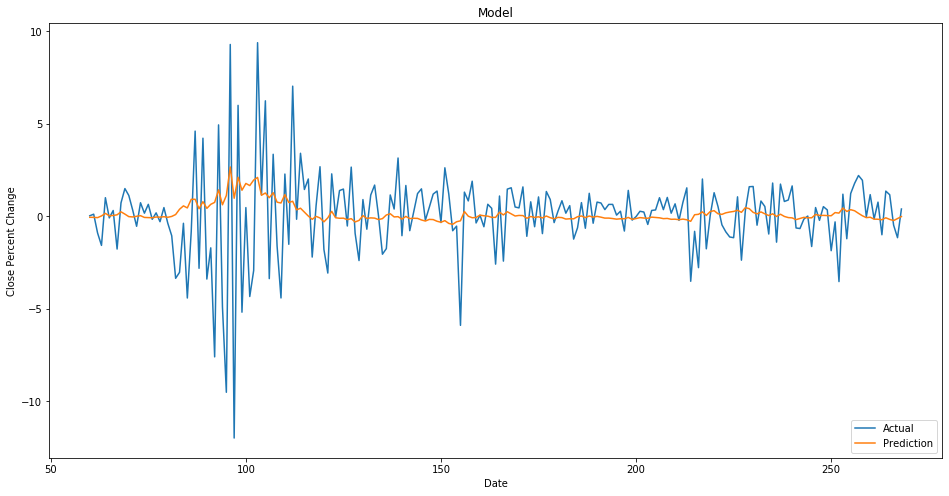

77.40384615384616
5856.029543000002
Annualized Return: 566.1915%
Baseline Return: 178.6629%


In [115]:
#df = pd.read_csv("S&P500 Data.csv")
df = pd.read_csv("Current S&P 500.csv")
dax_df = pd.read_csv("Current Dax.csv")
#adding in Dax data
#dax_df = pd.read_csv("Dax Data.csv")
#drop Adj Close because it's the same as Close
del df["Adj Close"]
del dax_df["Adj Close"]
#df = df.join(dax_df, rsuffix = "_Dax")
df = pd.merge(df, dax_df, left_on="Date", right_on="Date")
df[["Open_y", "High_y", "Low_y", "Close_y", "Volume_y"]] = df[["Open_y", "High_y", "Low_y", "Close_y", "Volume_y"]].shift(-1)
del df["Date"]
df = df.dropna()
df = df.reset_index(drop=True)

#for S&P500
five_avg = 1269.48
prev = 258.630005
five_avg_list = [248.208, 250.82, 253.68, 256.322, 255.586]
for close in range(5, len(df.index)):
    five_avg -= prev
    five_avg += df.loc[close]["Close_x"]
    five_avg_list.append(five_avg/5)
    prev = df.loc[close - 5]["Close_x"]
df["5_Day_Average_x"] = five_avg_list
#now for the Dax
five_avg = 1000
prev = 1006.010010
five_avg_list = [1006, 1010, 1018, 1001, 1000]
for close in range(5, len(df.index)):
    five_avg -= prev
    five_avg += df.loc[close]["Close_y"]
    five_avg_list.append(five_avg/5)
    prev = df.loc[close - 5]["Close_x"]
df["5_Day_Average_y"] = five_avg_list
percent_x = [0]
percent_y = [0]
for close in range(len(df.index) - 1):
    prev_x = df.loc[close]["Close_x"]
    curr_x = df.loc[close+1]["Close_x"]
    percent_x.append(round((curr_x - prev_x) / prev_x * 100, 4))
    prev_y = df.loc[close]["Close_y"]
    curr_y = df.loc[close+1]["Close_y"]
    percent_y.append(round((curr_y - prev_y) / prev_y * 100, 4))
df["Close_x_Percent_Change"] = percent_x
df["Close_y_Percent_Change"] = percent_y

data = df.filter(["Close_x_Percent_Change"])
#Converting the dataframe to a numpy array
dataset = data.values

#getting the saved model
model = keras.models.load_model("test")

#Test data
# test_data = scaled_data[training_data_length - 100: , :]
test_data = dataset[: , :]
#Creating the x_test and y_test data sets
x_test = []
y_test = dataset[0: , :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i - 60: i, 0])

#Convert x_test to a numpy array
x_test = np.array(x_test)
#Reshape the data into 3 dim
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

#Get the models predicted close price
pred = model.predict(x_test)
#have to undo the scaling
#pred = scaler.inverse_transform(pred)

actual = data[60: ]
actual["Prediction"] = pred
#plotting the data
plt.figure(figsize = (16,8))
plt.plot(actual[["Close_x_Percent_Change", "Prediction"]])
plt.title("Model")
plt.xlabel("Date")
plt.ylabel("Close Percent Change")
plt.legend(["Actual", "Prediction"], loc = "lower right")
plt.show()

up_actual = []
up_pred = []
actual = actual.reset_index()
for row in range(len(actual.index) - 1):
    if actual.loc[row]["Close_x_Percent_Change"] >= actual.loc[row+1]["Close_x_Percent_Change"]:
        up_actual.append(0)
    else:
        up_actual.append(1)
    if actual.loc[row]["Prediction"] >= actual.loc[row+1]["Prediction"]:
        up_pred.append(0)
    else:
        up_pred.append(1)
correct = 0
for i in range(len(up_actual)):
    if up_actual[i] == up_pred[i]:
        correct += 1
print(correct / len(up_actual) * 100)

money = 5000
start = 5000
amount = 0
new_df = df[60:].reset_index()
new_df = new_df.join(actual["Prediction"])
new_df.drop(new_df.tail(3).index, inplace=True)
pd.set_option('display.max_rows', new_df.shape[0]+1)
for row in range(len(new_df.index) - 1):
    #predicted to go UP tomorrow
    if up_pred[row] == 0 and money > 0:
        while True:
            if money - new_df.loc[row]["Open_x"] >= 0:
                amount += 1
                money -= new_df.loc[row]["Open_x"]
            else:
                break
    #predicted to go DOWN tomorrow
    elif up_pred[row] == 1 and amount != 0:
        money += new_df.loc[row]["Close_x"] * amount
        amount = 0
money += new_df.loc[len(new_df) - 1]["Close_x"] * amount
print(money)
r = (money - start) / start
b_r = (new_df.loc[len(new_df) - 1]["Close_x"] - new_df.loc[0]["Open_x"]) / new_df.loc[0]["Open_x"]
annualized_return = (1 + r)**(12) - 1
baseline_return = (1 + b_r)**(12) - 1
print("Annualized Return: " + str(round(annualized_return * 100, 4)) + "%")
print("Baseline Return: " + str(round(baseline_return * 100, 4)) + "%")

In [102]:
new_df

,index,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y,5_Day_Average_x,5_Day_Average_y,Close_x_Percent_Change,Close_y_Percent_Change,Prediction
0,60,3330.020020,3337.770020,3320.040039,3321.750000,3619850000,13455.900390,13486.139650,13382.230470,13388.419920,90749900.0,1166.438016,113760.183846,0.0289,-0.9421,-0.054884
1,61,3315.770020,3326.879883,3301.870117,3325.540039,3764860000,13512.839840,13604.849610,13510.790040,13576.679690,87986400.0,1174.916044,115818.889804,0.1141,1.4061,-0.057020
2,62,3333.100098,3333.179932,3281.530029,3295.469971,3707130000,13374.990230,13399.419920,13195.280270,13204.769530,101409200.0,1176.152030,117801.985702,-0.9042,-2.7393,-0.072146
3,63,3247.159912,3258.850098,3234.500000,3243.629883,3823100000,13274.009770,13327.120120,13163.360350,13323.690430,91825300.0,1161.515995,119803.361776,-1.5731,0.9006,0.019407
4,64,3255.350098,3285.780029,3253.219971,3276.239990,3526720000,13316.419920,13371.299810,13296.030270,13345.000000,67876800.0,1150.839970,121806.437753,1.0054,0.1599,0.156962
5,65,3289.459961,3293.469971,3271.889893,3273.399902,3584500000,13186.490230,13262.179690,13118.969730,13157.120120,100706100.0,1141.361942,123773.703769,-0.0867,-1.4079,0.027342
6,66,3256.449951,3285.909912,3242.800049,3283.659912,3787250000,13196.799810,13208.469730,12973.700200,12981.969730,106903800.0,1133.743925,125705.747715,0.3134,-1.3312,0.045969
7,67,3282.330078,3282.330078,3214.679932,3225.520020,4527830000,13033.169920,13077.570310,12987.530270,13045.190430,81389100.0,1113.739921,127649.677793,-1.7706,0.4870,0.080407
8,68,3235.659912,3268.439941,3235.659912,3248.919922,3757910000,13135.610350,13282.629880,13131.070310,13281.740230,80887400.0,1104.429911,129646.931845,0.7255,1.8133,0.241714
9,69,3280.610107,3306.919922,3280.610107,3297.590088,3995320000,13224.269530,13488.580080,13223.139650,13478.330080,108453900.0,1115.221952,131693.871884,1.4980,1.4802,0.118081
